In [54]:
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
import requests
import regex
import json
import os

from tensorflow import keras
import tensorflow as tf
import pandas as pd

## Motando o Dataset

In [2]:
!rm -rf img
!mkdir img

'rm' nao � reconhecido como um comando interno
ou externo, um programa oper�vel ou um arquivo em lotes.


In [55]:
def save_image(id, image_src):
  path = f"img/{id}.{image_src.split('.')[-1]}"
  
  if path in os.listdir("img"):
    return path
  
  with open(path, "wb") as imagem:
    imagem.write(requests.get(image_src).content)
  return path

In [56]:
all_pokemon_url = "https://pokemondb.net/pokedex/all"
all_pokemon_soup = BeautifulSoup(requests.get(all_pokemon_url).text)

pokedex_table_raw = all_pokemon_soup.find("table", {"id":"pokedex"})

all_pokemons = {
    pokemon_line.find("td", {"class":"cell-num"}).text : {
        "id" : pokemon_line.find("td", {"class":"cell-num"}).text,
        "name" : pokemon_line.find("td", {"class":"cell-name"}).text,
        "url" : "https://pokemondb.net" + pokemon_line.find("td", {"class":"cell-name"}).find("a")['href']
    } for pokemon_line in pokedex_table_raw.find_all("tr") if type(pokemon_line.find("td", {"class":"cell-num"})) != type(None)
}

Fazendo o download dos dados, normalmente demora algo próximo de 8 minutos

In [58]:
pokemon_types_by_id = []
for pokemon_info in all_pokemons.values():
    pokemon_soup = BeautifulSoup(requests.get(pokemon_info["url"]).text)

    pokedex_data = pokemon_soup.find("h2", string="Pokédex data").find_parent()

    pokemon_name = pokemon_soup.find("h1").text
    pokemon_img_src = pokemon_soup.find("div", {"class" : "grid-row"}).find("img")["src"]
    pokemon_id = regex.match(r"[0-9]+.[0-9]+", pokedex_data.find("th", string="National №").find_next().text)[0]
    pokemon_img_path = save_image(pokemon_id, pokemon_img_src)

    pokemon_types = [ptype.text for ptype in pokedex_data.find("th", string="Type").find_parent().find_all("a")]

    pokemon_types_by_id.append([pokemon_id, pokemon_img_path, pokemon_types])
    
    add_soup = BeautifulSoup(requests.get(pokemon_info["url"].replace('pokedex', 'artwork')).text)
    add_images = [img['src'] for img in add_soup.find('div', {'class' : 'grid-row component-lg'}).find_all('img')]
    for i, additional_image in enumerate(add_images):
        save_image(f"{pokemon_id}-{i}", additional_image)
        pokemon_types_by_id.append([f"{pokemon_id}-{i}", additional_image, pokemon_types])

        


Separando em Daraframe de Treino e Teste

In [59]:
df = pd.DataFrame(pokemon_types_by_id, columns=['id', 'src', 'types'])
df["types"] = df["types"].apply(lambda x : x[0])
unique_types = list(df["types"].unique())
df["types"] = df["types"].apply(lambda x: unique_types.index(x))

In [60]:
df_train, df_test = \
tf.keras.utils.image_dataset_from_directory("img",
                                            labels=list(df["types"].values),
                                            batch_size=8,
                                            seed=42,
                                            shuffle=True,
                                            subset="both",
                                            validation_split=0.2
)

Found 3270 files belonging to 18 classes.
Using 2616 files for training.
Using 654 files for validation.


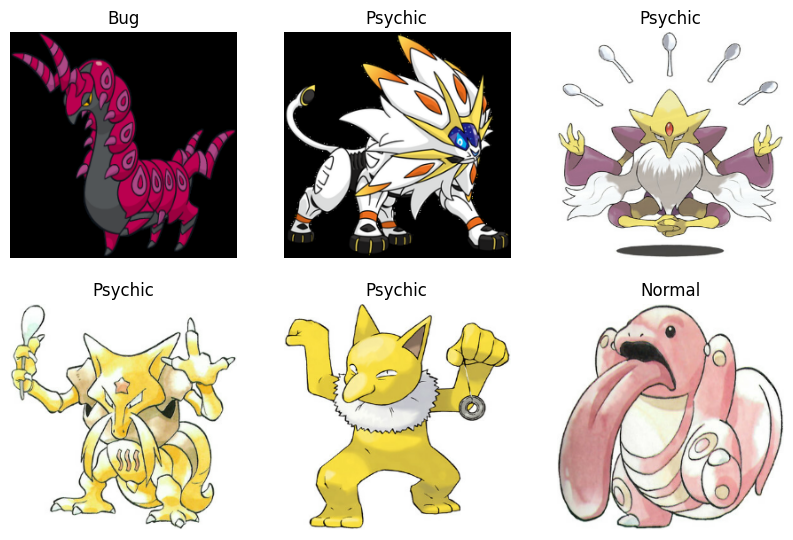

In [61]:
plt.figure(figsize=(10, 10))
for images, labels in df_train.take(1):
  for i in range(6):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(unique_types[labels[i]])
    plt.axis("off")

In [62]:
class EarlyStopping(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        if (logs is not None) and (logs.get('accuracy') > 0.90):
            print("\nReached 90% accuracy so cancelling training!")
            self.model.stop_training = True

In [69]:

# Add convolutions and max pooling
model = tf.keras.models.Sequential([
    tf.keras.Input(shape=(256, 256, 3)),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(16, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(126, activation='relu'),
    tf.keras.layers.Dense(50, activation='relu'),
    tf.keras.layers.Dense(18, activation='softmax'),
], name='pokemon_model')

model.summary()

# Use same settings
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


Model: "pokemon_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_26 (Conv2D)              │ (None, 254, 254, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_26 (MaxPooling2D) │ (None, 127, 127, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_27 (Conv2D)              │ (None, 125, 125, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_27 (MaxPooling2D) │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_9 (Flatten)             │ (None, 246016)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_28 (Dense)                │ (None, 256)            │    62,980,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ (None, 126)            │        32,382 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_30 (Dense)                │ (None, 50)             │         6,350 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_31 (Dense)                │ (None, 18)             │           918 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 63,039,394 (240.48 MB)

 Trainable params: 63,039,394 (240.48 MB)

 Non-trainable params: 0 (0.00 B)

In [70]:
print(f'\nMODEL TRAINING:')
history = model.fit(df_train,
                    callbacks=[EarlyStopping()],
                    epochs=10)


MODEL TRAINING:
Epoch 1/10
327/327 ━━━━━━━━━━━━━━━━━━━━ 272s 821ms/step - accuracy: 0.1189 - loss: 194.7085
Epoch 2/10
327/327 ━━━━━━━━━━━━━━━━━━━━ 256s 784ms/step - accuracy: 0.2500 - loss: 2.4944
Epoch 3/10
327/327 ━━━━━━━━━━━━━━━━━━━━ 251s 769ms/step - accuracy: 0.4252 - loss: 1.8992
Epoch 4/10
327/327 ━━━━━━━━━━━━━━━━━━━━ 245s 749ms/step - accuracy: 0.6111 - loss: 1.3896
Epoch 5/10
327/327 ━━━━━━━━━━━━━━━━━━━━ 244s 745ms/step - accuracy: 0.6230 - loss: 1.4256
Epoch 6/10
327/327 ━━━━━━━━━━━━━━━━━━━━ 234s 715ms/step - accuracy: 0.7828 - loss: 0.8592
Epoch 7/10
327/327 ━━━━━━━━━━━━━━━━━━━━ 234s 715ms/step - accuracy: 0.8235 - loss: 0.7708
Epoch 8/10
327/327 ━━━━━━━━━━━━━━━━━━━━ 241s 737ms/step - accuracy: 0.8709 - loss: 0.5084
Epoch 9/10
327/327 ━━━━━━━━━━━━━━━━━━━━ 0s 778ms/step - accuracy: 0.9057 - loss: 0.4445
Reached 90% accuracy so cancelling training!
327/327 ━━━━━━━━━━━━━━━━━━━━ 254s 778ms/step - accuracy: 0.9057 - loss: 0.4443


In [71]:
# Evaluate on the test set
print(f'\nMODEL EVALUATION:')
test_loss = model.evaluate(df_test)


MODEL EVALUATION:
82/82 ━━━━━━━━━━━━━━━━━━━━ 7s 86ms/step - accuracy: 0.4915 - loss: 4.0182


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


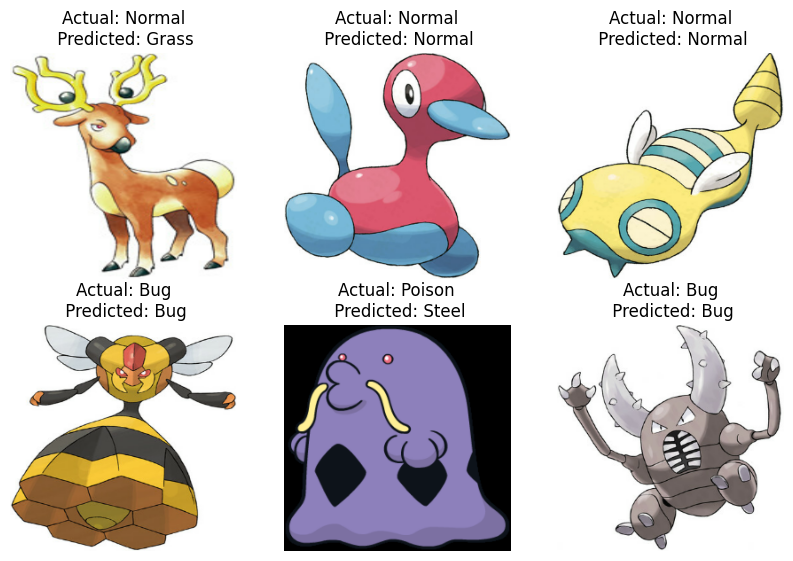

In [72]:
plt.figure(figsize=(10, 10))

for images, labels in df_test.take(1):
  prediction = model.predict(images)
  for i in range(6):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(f"Actual: {unique_types[labels[i]]}\n Predicted: {unique_types[prediction[i].argmax()]}")
    plt.axis("off")